In [2]:
import skimage
import pickle
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
from random import random
from scipy import stats
from scipy.spatial.distance import cityblock
from math import sqrt

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

"""OPENING ALL THE FILES INTO ONE ARRAY - An Array of 50000 by 3072 """

a= 'D:/cifar-10-python/data_batch_1'
b= 'D:/cifar-10-python/data_batch_2'
c= 'D:/cifar-10-python/data_batch_3'
d= 'D:/cifar-10-python/data_batch_4'
e= 'D:/cifar-10-python/data_batch_5'

#Adding All Files into one Array
datadict = unpickle(a)
X = datadict["data"].astype("uint8") #Basic Data Set with 10,000 rows and 3072 columns
Y = datadict["labels"] #contains the number associated with label name

for i in [b,c,d,e]:
    datadict = unpickle(i)
    X1 = datadict["data"].astype("uint8") #Basic Data Set with 10,000 rows and 3072 columns
    Y1 = datadict["labels"] #contains the number associated with label name

    X = np.vstack((X,X1)) # Vertical Stack
    Y = np.hstack((Y,Y1)) # horizontal Stack
  
"""BRINGING IN THE LABEL DATA"""

#number from labels associates with one of the 10 names in this
labeldict = unpickle('D:/cifar-10-python/batches.meta')
label_names = labeldict["label_names"] 

Z = X #Simplified, just 50,000 rows and 3072 columns

# #Reshaping the data to view it in R,G,B arrays and print the image as well, previous data was just rows of bytes
X = X.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 
Y = np.array(Y)


"""BRINGING IN THE TEST DATA"""

#Bringing in Test Data
testdict = unpickle('D:/cifar-10-python/test_batch')
testdict.keys()
X_test = testdict['data'].astype("uint8")
Y_test = np.array(testdict['labels']) #Must convert to array before working

Z_test = X_test #Simplified form of 10,000 x 3072 

# #Reshaping the data to view it, previous data was just rows of bytes
X_test = X_test.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") 
Y_test = np.array(Y_test)

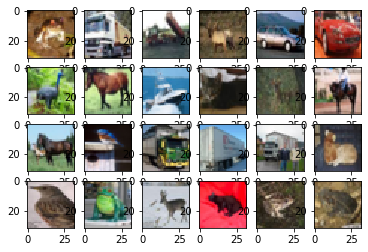

In [3]:
"""CODE FOR SHOWING THE IMAGES """

#Plotting Some Images 
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(X[i])
plt.show()

# for i in range(X.shape[0]):
#     # Show some images randomly
#     if random() > 0.999:
#         plt.figure(1);
#         plt.clf()
#         plt.imshow(X[i])
#         plt.title(f"Image {i} label={label_names[Y[i]]} (num {Y[i]})")
#         plt.pause(0.5)


In [4]:
"""
SPLITTING INTO TEST AND TRAIN DATA (Smaller sets are taken during development phase)
"""
X_train = X
X_test = X_test
Y_train = Y
Y_test = Y_test

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


## 1. CIFAR-10 – Bayesian classifier (good) (40 points)

In [4]:
skimage.transform.resize(X_train[0],(1,1)) #checking transformation

array([[[0.55098039, 0.40882353, 0.24705882]]])

In [645]:
# def cifar10_color(X,dim1=1,dim2=1):
#     """
#     Downsizes the entire image set to 1x1 or specified dimensions
#     param1: X array of images
#     """
#     a = len(X)
#     R = np.resize(X,(a,dim1,dim2,3))
# #     R = skit.resize(X,(a,dim1,dim2,3))
#     return R #Resized Image

In [646]:
# #from np resize
# P= np.resize(X_train[0],(2,2,3))
# plt.imshow(P)
# P.shape
# plt.show()
# #from skimage transform resize
# O = skit.resize(X_train[0],(2,2))
# plt.imshow(O)
# O.shape
# type(O[0][0][0])
# plt.show()

In [5]:
"""SORTING CLASSES 5k of each class"""

I = np.argsort(Y_train) #Sorted class numbers indexes from Y_train array from 0 to 9

X_train = X_train[I] #Sorted  resized images based on class numbers from lowest to highest
Y_train = Y_train[I] #sorted class numbers from indexes in I
# print(X_train[0:10],Y_train[0:10])

In [6]:
skimage.transform.resize(X_train[0],(1,1)) #checking transformation

array([[[0.40882353, 0.49607843, 0.65882353]]])

In [7]:
def cifar10_color(X):
    """
    Downsizes the entire image to 1x1 or specified dimensions
    param1: X array of images
    """

    RGB = np.zeros((X.shape[0],3))
    for i in range(X.shape[0]):
        RGB[i] = skimage.transform.resize(X[i],(1,1))

    return RGB

In [8]:
"""RESIZING IMAGES TO 1x1"""

X_train_1 = cifar10_color(X_train)
X_test_1 = cifar10_color(X_test)

print(X_train_1.shape, X_test_1.shape)

(50000, 3) (10000, 3)


In [13]:
X_train_1[0] #Checking

array([0.40882353, 0.49607843, 0.65882353])

In [21]:
"""
SPLITTING IMAGES INTO THEIR CLASSES
"""
c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9 = np.array_split(X_train_1,10)  #Splitting training images in their classes
C = np.array_split(X_train,10)

In [22]:
"""
DEFINING FUNCTION TO GIVE US VALUES OF MU, SIGMA AND P FOR ALL CLASSES 1x1 Images
"""
def cifar_10_naivebayes_learn(Xp,Y):
    """
    Xp = training data
    Y = training data classes
    """
    
    classes = len(np.bincount(Y))

    C = np.array_split(Xp,classes)
    
    mu = np.zeros((10,3))
    sigma = np.zeros((10,3))
    p = np.zeros((10,1))
    
    for i in range(10):
        mu[i] = np.mean(C[i],axis=0)
        sigma[i] = np.std(C[i],axis=0) #------------------------RECHECK THIS. var or sd. FINAL: GIVES STD DEV = SIGMA
        p[i] = len(C[i])/len(Xp)    #5,000/50,000
    
    return mu, sigma, p

#Incase of univaraite, sigma is Standard deviation
#incase of multivariate sigma is variance

In [26]:
"""
GETTING VALUES OF MEAN, STANDARD DEVIATION AND PRIOR
"""
mu_1,sigma_1,p_1 = cifar_10_naivebayes_learn(X_train_1,Y_train) #For All Classes
print(mu_1,"\n\n", sigma_1,"\n\n", p_1)

[[0.52025078 0.55423902 0.58234059]
 [0.46432529 0.44676353 0.44028529]
 [0.48471078 0.48612137 0.41901529]
 [0.49162353 0.45174176 0.41037608]
 [0.46786902 0.46011627 0.37332196]
 [0.49870392 0.46224863 0.41405706]
 [0.46617843 0.43325843 0.33925   ]
 [0.4957451  0.47206471 0.40943686]
 [0.48735353 0.52104275 0.54938608]
 [0.48999333 0.47523137 0.46795294]] 

 [[0.1513226  0.13936802 0.16187351]
 [0.11859051 0.1211884  0.13505205]
 [0.13845736 0.13152152 0.15876932]
 [0.13313431 0.12876379 0.13807037]
 [0.11949397 0.10978325 0.12979021]
 [0.12031818 0.11348003 0.12324026]
 [0.12686829 0.11953258 0.13178148]
 [0.10796025 0.10303614 0.11297782]
 [0.12276019 0.11223772 0.1206655 ]
 [0.10553139 0.10193969 0.11218725]] 

 [[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]


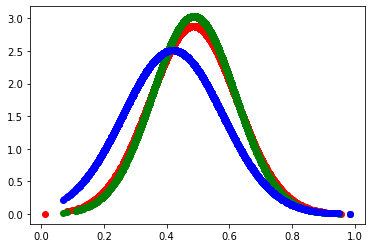

In [27]:
"""
PLOTTING THE RGB CHANNELS OF A SINGLE CLASS
"""
# x_test_r = np.zeros(5000)
# x_test_g = np.zeros(5000)
# x_test_b = np.zeros(5000)

C = c_2.reshape(5000,3)

sigma_c_r = sigma_1[2][0]
sigma_c_g = sigma_1[2][1]
sigma_c_b = sigma_1[2][2]

mu_c_r = mu_1[2][0]
mu_c_g = mu_1[2][1]
mu_c_b = mu_1[2][2]

x_test_r = C[:,0] #for R - RED
x_test_g = C[:,1] #for G - GREEN
x_test_b = C[:,2] #for B - BLUE

# Testing ready made function with my own function
p_r = stats.norm(mu_c_r,(sigma_c_r)).pdf(x_test_r) #Here input standard deviation
p_g = stats.norm(mu_c_g,(sigma_c_g)).pdf(x_test_g)
p_b = stats.norm(mu_c_b,(sigma_c_b)).pdf(x_test_b)

# p_r = gaussian(x_test_r, mu_c_r, sigma_c_r)
# p_g = gaussian(x_test_g, mu_c_g, sigma_c_g)
# p_b = gaussian(x_test_b, mu_c_b, sigma_c_b)

    

# plt.plot(x_test_r,p_r,'bd')
plt.plot(x_test_r, p_r, 'ro')
plt.plot(x_test_g, p_g, 'go')
plt.plot(x_test_b, p_b, 'bo')

In [51]:
# def gaussian(x,mu,sigma): #x = position, mu = mean, sigma = variance
#     f_x = 1/np.sqrt(2*np.pi*sigma)*np.exp((-1/(2*sigma))*((x-mu)**2))
#     return f_x

In [33]:
"""
NAIVE BAYES IMAGE CLASSIFIER for 1x1 Image
"""
def cifar10_classifier_naivebayes(x,mu,sigma,p):
    """
    Function predicts the class of a given image
    x = simgle image
    mu = means of all classes
    sigma = variances of all classes
    p = prior probability of each class
    """

#     x = x.reshape(3)
#     p = 0.1

    x_test_r = x[0] #for R - RED
    x_test_g = x[1] #for G - GREEN
    x_test_b = x[2] #for B - BLUE

    P_class_x = np.zeros(10)

    for i in range(10):

        mu_c_r = mu[i][0] #mean of class i red channel
        mu_c_g = mu[i][1] #mean of class i green channel
        mu_c_b = mu[i][2] #mean of class i blue channel

        sigma_c_r = sigma[i][0] #sigma of class i red channel
        sigma_c_g = sigma[i][1] #sigma of class i green channel
        sigma_c_b = sigma[i][2] #sigma of class i blue channel

        #probability of a class for the given image x
        #numerator = gaussian(x_test_r,mu_c_r,sigma_c_r)*gaussian(x_test_g,mu_c_g,sigma_c_g)*gaussian(x_test_b,mu_c_b,sigma_c_b)*p
        numerator = stats.norm(mu_c_r,(sigma_c_r)).pdf(x_test_r)*stats.norm(mu_c_g,(sigma_c_g)).pdf(x_test_g)*stats.norm(mu_c_b,(sigma_c_b)).pdf(x_test_b)*p
        
        denomenator = np.zeros(10)
        #calculating the sum of all probabilities
        for j in range(10):

            mu_c_r = mu[j][0]
            mu_c_g = mu[j][1]
            mu_c_b = mu[j][2]

            sigma_c_r = sigma[j][0]
            sigma_c_g = sigma[j][1]
            sigma_c_b = sigma[j][2]
            
            #denomenator[j] = gaussian(x_test_r,mu_c_r,sigma_c_r)*gaussian(x_test_g,mu_c_g,sigma_c_g)*gaussian(x_test_b,mu_c_b,sigma_c_b)*p
            denomenator[j] = stats.norm(mu_c_r,(sigma_c_r)).pdf(x_test_r)*stats.norm(mu_c_g,(sigma_c_g)).pdf(x_test_g)*stats.norm(mu_c_b,(sigma_c_b)).pdf(x_test_b)*p
        
        #summing the denomenator gaussian probabilites
        denomenator = sum(denomenator)
        
        #collecting all the probilities
        P_class_x[i] = numerator/denomenator
    
    #taking class with highest probability
    predicted_class = P_class_x.argmax()
#     print(predicted_class)
#     label_names[predicted_class]
    return predicted_class

    

In [34]:
"""
DEFINING EVALUATION FUNCTION
"""
def class_acc(pred,gt):

    count = np.count_nonzero(gt == pred)

    accuracy = count*100/len(pred)

#     print("Accuracy:",accuracy,"%")
    
    return accuracy

In [38]:
"""
TESTING THE ACCURACY OF THE PREDICTIONS FROM NAIVE BAYES 1x1
"""

x = X_test_1 #Resized Test Images to 1x1
mu = mu_1 #Mean of size(10,3)
sigma = sigma_1 #Simga size(10,3)
p = 0.1

pred = np.zeros(len(x)) #Pred length is 10,000

for i in range(len(x)):

    pred[i] = cifar10_classifier_naivebayes(x[i],mu,sigma,p)

acc = class_acc(pred,Y_test)

print("NAIVE BAYES ACCURACY =",acc,"%")


NAIVE BAYES ACCURACY = 20.8 %


## 2. CIFAR-10 – Bayesian classifier (better) (20 points)

In [9]:
"""
DEFINING FUNCTION FOR MULTIVARIATE GAUSSIAN
"""
def multi_gaussian(x,mu,sigma,k=3):

    det_cov = np.linalg.det(sigma)
    inv_cov = np.linalg.inv(sigma)

    A = np.transpose(x-mu)
    B = x-mu

    constant = (1/(np.sqrt(((2*np.pi)**k)*det_cov)))

    exponent = np.exp(-0.5*np.matmul(np.matmul(A,inv_cov),B)) #np.exp(-0.5*A*inv_cov*B)

    f_x = constant * exponent
    
    return f_x;

In [40]:
"""
DEFINING FUNCTION FOR EXTRACTING VALUE OF MEAN, STD DEV & PRIOR OF TRAINING DATA FOR MULTIVARIATE GAUSSIAN 1X1
"""
def cifar_10_bayes_learn(Xf,Y):
    """
    Xf = training data
    Y = training data classes
    """
    
    classes = len(np.bincount(Y))

    C = np.array_split(Xf,classes)
    
    mu = np.zeros((10,3))
    sigma = np.zeros((10,3,3))
    p = np.zeros((10,1))
    
    for i in range(10):
        mu[i] = np.mean(C[i],axis=0)
        sigma[i] = np.cov(C[i],rowvar=False)
        p[i] = len(C[i])/len(Xf)    #5,000/50,000
    
    return mu, sigma, p

#Incase of univaraite, sigma is Standard deviation
#incase of multivariate sigma is variance
    

In [42]:
"""
MEAN, SIGMA and Prior FOR MUTIVARIATE GAUSSIAN 1x1 Image
"""
mu_1,sigma_1,p_1 = cifar_10_bayes_learn(X_train_1,Y_train)
print(mu_1.shape,sigma_1.shape, p_1.shape)

(10, 3) (10, 3, 3) (10, 1)


In [43]:
"""CHECKS, manual vs auto multivariate calculation""" 
# mu_mult = mu_1[0]
# sigma_mult = sigma_1[0]
# x = X_test[0]

# print(multi_gaussian(x,mu_mult,sigma_mult)*p_1[0])

# print(stats.multivariate_normal.pdf(x,mean=mu_mult,cov=sigma_mult)*p_1[0])

# # sigma_mult.shape

'CHECKS, manual vs auto multivariate calculation'

In [45]:
def cifar10_classifier_bayes(x,mu,sigma,p):
    """
    Function Computes Class Accuracy Based on MULTIVARIATE GAUSSIAN EQUATION
    """
    p = 0.1

    x_test = x
#     print(x_test)

    P_class_x = np.zeros((10,1))

    for i in range(10):
    #     print(i)

        mu_c = mu[i] #Vector of Class RGB means
    #     print(mu_c)

        sigma_c = sigma[i] #Covariance Matrix
    #     print(sigma_c)

        #probability of a class for the given image x
        #numerator = multi_gaussian(x_test,mu_c,sigma_c) * p
        numerator = stats.multivariate_normal.pdf(x_test,mean=mu_c,cov=sigma_c) * p
    #     print(numerator)

        denomenator = np.zeros((10,1))
        #calculating the sum of all probabilities

        for j in range(10):

            mu_c = mu[j] #Vector of Class RGB means

            sigma_c = sigma[j] #Covariance Matrix

            #denomenator[j] = multi_gaussian(x_test,mu_c,sigma_c) * p
            denomenator[j] = stats.multivariate_normal.pdf(x_test,mean=mu_c,cov=sigma_c) * p

        #summing the denomenator gaussian probabilites
        denomenator = sum(denomenator)

        #collecting all the probilities
        P_class_x[i] = numerator/denomenator

    #taking class with highest probability
    predicted_class = P_class_x.argmax()
#     print(P_class_x)
#     print(predicted_class)
#     label_names[predicted_class]
    return predicted_class


In [48]:
"""
TESTING THE ACCURACY OF THE PREDICTIONS FROM MULTIVARIATE NAIVE BAYES 1X1
"""

x = X_test_1
mu = mu_1
sigma = sigma_1
p = 0.1

pred = np.zeros(len(x))

for i in range(len(x)):

    pred[i] = cifar10_classifier_bayes(x[i],mu,sigma,p)

acc = class_acc(pred,Y_test)

print("MULTIVARIATE BAYES 1x1 ACCURACY =",acc,"%")

MULTIVARIATE BAYES 1x1 ACCURACY = 24.79 %


## 3. CIFAR-10 – Bayesian classifier (best) (20 points)

In [602]:
# skimage.transform.resize(X_train[0],(3,2,2))

In [603]:
# def cifar10_2x2_color(X):
#     """
#     Downsizes the entire image to 2x2 or specified dimensions
#     param1: X array of images
#     """

#     RGB = np.zeros((X.shape[0],3,2,2))
# #     RGB = np.zeros((X.shape[0],2,2,3)
#     for i in range(len(X)):
#         RGB[i] = skimage.transform.resize(X[i],(3,2,2))

#     return RGB

In [49]:
def cifar10_2x2_color(X):
    """
    Downsizes the entire image to 2x2 or specified dimensions
    param1: X array of images
    """

    RGB = np.zeros((X.shape[0],12))
#     RGB = np.zeros((X.shape[0],2,2,3)
    for i in range(len(X)):
        temp = skimage.transform.resize(X[i],(2,2))
        RGB[i] = temp.reshape(12)

    return RGB

In [52]:
X_test.shape, X_train.shape

((10000, 32, 32, 3), (50000, 32, 32, 3))

In [53]:
"""
TRANSFORMING INTO 2x2 IMAGES
"""
X_train_2 = cifar10_2x2_color(X_train)
X_test_2 = cifar10_2x2_color(X_test)

print(X_train_2.shape, X_test_2.shape)

(50000, 12) (10000, 12)


In [54]:
np.mean(X_train_2,axis=0).shape, np.cov(X_train_2,rowvar=False).shape #checking

((12,), (12, 12))

In [55]:
"""
DEFINING FUNCTION FOR EXTRACTING VALUE OF MEAN, STD DEV & PRIOR OF TRAINING DATA FOR MULTIVARIATE GAUSSIAN 2x2
"""
def cifar_10_bayes_learn(Xf,Y):
    """
    Xf = training data
    Y = training data classes
    """
    
    classes = len(np.bincount(Y))

    C = np.array_split(Xf,classes)
    
    mu = np.zeros((10,12)) #12 means for each class
#     print(mu)
    sigma = np.zeros((10,12,12)) # 12 by 12 covariance matrix for each class
#     print(sigma)
    p = np.zeros((10,1))
    
    for i in range(10):
#         print(i)
        mu[i] = np.mean(C[i],axis=0)
        var = np.cov(C[i],rowvar=False) #Covariance
        sigma[i] = var
        p[i] = len(C[i])/len(Xf)    #5,000/50,000
    
    return mu, sigma, p

#Incase of univaraite, sigma is Standard deviation
#incase of multivariate sigma is variance
    

In [56]:
"""
TAKING MEAN, SIGMA and Prior FROM THE NEW 2x2 TRAINING DATA
"""
mu_2, sigma_2, p_2 = cifar_10_bayes_learn(X_train_2,Y_train)

print(mu_2.shape, sigma_2.shape, p_2.shape)

(10, 12) (10, 12, 12) (10, 1)


In [92]:
"""
BAYSIAN CLASSIFIER FUNCTION
"""

def cifar10_classifier_bayes(x,mu,sigma,p):
    """
    Function Computes Class Accuracy Based on MULTIVARIATE GAUSSIAN EQUATION
    """
    p = 0.1

    x_test = x
#     print(x_test)

    P_class_x = np.zeros((10,1))

    for i in range(10):
#         print(i)

        mu_c = mu[i] #Vector of Class RGB means 12x1
#         print(mu_c)

        sigma_c = sigma[i] #Covariance Matrix 12x12
#         print(sigma_c)

        #probability of a class for the given image x
        #numerator = multi_gaussian(x_test,mu_c,sigma_c) * p
#         numerator = stats.multivariate_normal.pdf(x_test,mean=mu_c,cov=sigma_c) * p
        numerator = stats.multivariate_normal.logpdf(x_test,mean=mu_c,cov=sigma_c) * p

    #     print(numerator)

        denomenator = np.zeros((10,1))
        #calculating the sum of all probabilities

        for j in range(10):

            mu_c = mu[j] #Vector of Class RGB means

            sigma_c = sigma[j] #Covariance Matrix

            #denomenator[j] = multi_gaussian(x_test,mu_c,sigma_c) * p
#             denomenator[j] = stats.multivariate_normal.pdf(x_test,mean=mu_c,cov=sigma_c) * p
            denomenator[j] = stats.multivariate_normal.logpdf(x_test,mean=mu_c,cov=sigma_c) * p

            
        #summing the denomenator gaussian probabilites
        denomenator = sum(denomenator)

        #collecting all the probilities
        P_class_x[i] = numerator/denomenator

    #taking class with highest probability
    predicted_class = P_class_x.argmax()
#     print(P_class_x)
#     print(predicted_class)
#     label_names[predicted_class]
    return predicted_class


In [61]:
"""
TESTING THE ACCURACY OF THE PREDICTIONS FROM MULTIVARIATE NAIVE BAYES
"""

x = X_test_2
mu = mu_2
sigma = sigma_2
p = 0.1

pred = np.zeros(len(x))

for i in range(len(x)):

    pred[i] = cifar10_classifier_bayes(x[i],mu,sigma,p)

acc = class_acc(pred,Y_test)

print("MULTIVARIATE BAYES 2x2 ACCURACY =",acc,"%")

MULTIVARIATE NAIVE BAYES 2x2 ACCURACY = 31.05 %


## GENERALIZING ALL FUNCTIONS FOR N x N Sizes

In [62]:
def cifar10_nxn_color(X,n):
    """
    Downsizes the entire image to nxn or specified dimensions
    param1: X array of images
    param2: n dimensions of images
    """

    RGB = np.zeros((X.shape[0],n*n*3))
#     RGB = np.zeros((X.shape[0],2,2,3)
    for i in range(len(X)):
        temp = skimage.transform.resize(X[i],(n,n))
        RGB[i] = temp.reshape(n*n*3)

    return RGB

In [63]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [67]:
"""
TRANSFORMING INTO 3x3 IMAGES
"""
X_train_3 = cifar10_nxn_color(X_train,3)
X_test_3 = cifar10_nxn_color(X_test,3)

print(X_train_3.shape, X_test_3.shape) # 3x3x3 = 27

(50000, 27) (10000, 27)


In [68]:
"""
DEFINING FUNCTION FOR EXTRACTING VALUE OF MEAN, STD DEV & PRIOR OF TRAINING DATA FOR MULTIVARIATE GAUSSIAN NxN image size
"""
def cifar_10_bayes_learn_nxn(Xf,Y):
    """
    Xf = training data
    Y = training data classes
    """
    
    classes = len(np.bincount(Y))

    C = np.array_split(Xf,classes)
    
    mu = np.zeros((10,Xf.shape[1])) #nxnx3 means for each class
#     print(mu)
    sigma = np.zeros((10,Xf.shape[1],Xf.shape[1])) # n*n*3 by n*n*3 covariance matrix for each class
#     print(sigma)
    p = np.zeros((10,1))
    
    for i in range(10):
#         print(i)
        mu[i] = np.mean(C[i],axis=0)
        var = np.cov(C[i],rowvar=False) #Covariance
        sigma[i] = var
        p[i] = len(C[i])/len(Xf)    #5,000/50,000
    
    return mu, sigma, p

#Incase of univaraite, sigma is Standard deviation
#incase of multivariate sigma is variance
    

In [72]:
"""
TAKING MEAN, SIGMA and Prior FROM THE NEW 3x3 TRAINING DATA
"""
mu_3, sigma_3, p_3 = cifar_10_bayes_learn_nxn(X_train_3,Y_train)

print(mu_3.shape, sigma_3.shape, p_3.shape)

(10, 27) (10, 27, 27) (10, 1)


In [81]:
"""
TESTING THE ACCURACY OF THE PREDICTIONS FROM MULTIVARIATE NAIVE BAYES NxN Size
"""

x = X_test_3
mu = mu_3
sigma = sigma_3
p = 0.1
n = 3

pred = np.zeros(len(x))

for i in range(len(x)):

    pred[i] = cifar10_classifier_bayes(x[i],mu,sigma,p) #This function does not need to change for nxn

acc = class_acc(pred,Y_test)

print("MULTIVARIATE BAYES",n,"x",n, "ACCURACY =",acc,"%")

MULTIVARIATE BAYES 3 x 3 ACCURACY = 39.97 %


In [82]:
"""
TRANSFORMING INTO 4x4 IMAGES
"""
X_train_4 = cifar10_nxn_color(X_train,4)
X_test_4 = cifar10_nxn_color(X_test,4)

print(X_train_4.shape, X_test_4.shape) # 4x4x3 = 48

(50000, 48) (10000, 48)


In [85]:
"""
TAKING MEAN, SIGMA and Prior FROM THE NEW 4x4 TRAINING DATA
"""
mu_4, sigma_4, p_4 = cifar_10_bayes_learn_nxn(X_train_4,Y_train)

print(mu_4.shape, sigma_4.shape, p_4.shape)

(10, 48) (10, 48, 48) (10, 1)


In [95]:
"""
TESTING THE ACCURACY OF THE PREDICTIONS FROM MULTIVARIATE NAIVE BAYES NxN Size
"""

x = X_test_4
mu = mu_4
sigma = sigma_4
p = 0.1
n = 4

pred = np.zeros(len(x))

for i in range(len(x)):

    pred[i] = cifar10_classifier_bayes(x[i],mu,sigma,p) #This function does not need to change for nxn

acc = class_acc(pred,Y_test)

print("MULTIVARIATE BAYES",n,"x",n, "ACCURACY =",acc,"%") #using logpdf for multivariate gaussian

MULTIVARIATE BAYES 4 x 4 ACCURACY = 38.6 %


In [96]:
"""
TRANSFORMING INTO 8x8 IMAGES
"""
X_train_8 = cifar10_nxn_color(X_train,8)
X_test_8 = cifar10_nxn_color(X_test,8)

print(X_train_8.shape, X_test_8.shape) # 8x8x3 = 192

(50000, 192) (10000, 192)


In [97]:
"""
TAKING MEAN, SIGMA and Prior FROM THE NEW 4x4 TRAINING DATA
"""
mu_8, sigma_8, p_8 = cifar_10_bayes_learn_nxn(X_train_8,Y_train)

print(mu_8.shape, sigma_8.shape, p_8.shape)

(10, 192) (10, 192, 192) (10, 1)


In [100]:
"""
TESTING THE ACCURACY OF THE PREDICTIONS FROM MULTIVARIATE NAIVE BAYES NxN Size
"""

x = X_test_8[:1000]
mu = mu_8
sigma = sigma_8
p = 0.1
n = 8

pred = np.zeros(len(x))

for i in range(len(x)):

    pred[i] = cifar10_classifier_bayes(x[i],mu,sigma,p) #This function does not need to change for nxn

acc = class_acc(pred,Y_test[:1000])

print("MULTIVARIATE BAYES",n,"x",n, "ACCURACY =",acc,"%") #using logpdf for multivariate gaussian

MULTIVARIATE BAYES 8 x 8 ACCURACY = 41.0 %


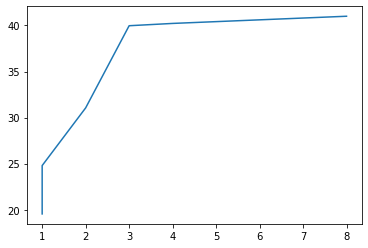

In [101]:
Image_sizes = ([1,1,2,3,4,8])
Accuracies = ([19.54,24.79,31.05,39.97,40.22,41])

plt.plot(Image_sizes,Accuracies)